# Computer VisionAssignment 2 Part 2b

In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms as T
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm_notebook

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.get_device_name()

cuda:0


'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

## Getting data

In [26]:
## General params
num_classes = 10
batch_size = 64
input_size = 224
RESNET_PATH_B_1 = './resnet18_b_1.pth'

In [7]:
IMAGE_RESIZE = (224,224)
transform = T.Compose([
    #Rescale(IMAGE_RESIZE),
    #T.RandomResizedCrop(input_size),
    T.Resize(input_size),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print('train + val:',trainset)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
print('train set:',trainset.dataset)
print('val set:', valset.dataset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloader_dict = {
    'train': trainloader,
    'val': valloader
}
print('complete dataloader:',dataloader_dict)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
train + val: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
train set: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
val set: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified
com

start transforming


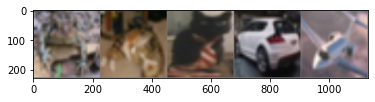

frog       cat        cat        car        plane     


In [8]:
## Checking out some training images

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    print('start transforming')
    img = img / 2 + 0.5     # unnormalize
    # print('1')
    npimg = img.numpy()
    # print('2')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # print('3')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:5]))
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(5)))

## Part 2b Model (ResNet with pretrained weights on ImageNet)

In [9]:
# resnet18 = models.resnet18(pretrained=True)
# resnet18.to(device)
# RESNET_PATH_B = './resnet18_b.pth'

In [10]:
# ## Accuracy on train data
# correct = 0
# total = 0
# # resnet18.load_state_dict(torch.load(RESNET_PATH_A))
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in tqdm_notebook(trainloader):
#         images, labels = data[0].to(device), data[1].to(device)
#         # calculate outputs by running images through the network
#         outputs = resnet18(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [13]:
## Advanced pytorch train function
import time
import copy
val_acc_history = []
train_acc_history = []
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    # val_acc_history = []
    # train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

### Feature extraction (1st approach)

In [14]:
## Now setting up model to only update the last fc layer
## initialize model as feature extractor
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    input_size = 224
    resnet_18b = models.resnet18(pretrained=use_pretrained)
    if feature_extract:
        # not updating other weights
        for param in resnet_18b.parameters():
            param.requires_grad = False
    in_fet_fc = resnet_18b.fc.in_features
    resnet_18b.fc = nn.Linear(in_fet_fc, num_classes)
    
    return resnet_18b, input_size
    
# resnet18 = models.resnet18(pretrained=True)
# resnet18.to(device)
RESNET_PATH_B = './resnet18_b.pth'
resnet_18b, input_size = initialize_model('resnet', num_classes,
                                          feature_extract=True, use_pretrained=True)
#print(resnet_18b)

In [15]:
##

learning_rate = 1e-2
num_epochs = 50
resnet_18b = resnet_18b.to(device)
params_to_update = []
for name, param in resnet_18b.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t',name)
optimizer = optim.Adam(params_to_update, lr=learning_rate)
criterion = nn.CrossEntropyLoss()

	 fc.weight
	 fc.bias


In [16]:
val_acc_history = []
train_acc_history = []
resnet_18b, val_acc, train_acc = train_model(resnet_18b, dataloader_dict,
                               criterion, optimizer,num_epochs,is_inception=False)

Epoch 0/49
----------
train Loss: 0.8622 Acc: 0.7246
val Loss: 0.8963 Acc: 0.7344

Epoch 1/49
----------
train Loss: 0.8083 Acc: 0.7550
val Loss: 0.7479 Acc: 0.7703

Epoch 2/49
----------
train Loss: 0.7928 Acc: 0.7654
val Loss: 0.8530 Acc: 0.7611

Epoch 3/49
----------
train Loss: 0.8016 Acc: 0.7634
val Loss: 0.8166 Acc: 0.7656

Epoch 4/49
----------
train Loss: 0.8090 Acc: 0.7688
val Loss: 0.8384 Acc: 0.7636

Epoch 5/49
----------
train Loss: 0.8215 Acc: 0.7654
val Loss: 0.8361 Acc: 0.7626

Epoch 6/49
----------
train Loss: 0.8124 Acc: 0.7682
val Loss: 0.7484 Acc: 0.7832

Epoch 7/49
----------
train Loss: 0.8076 Acc: 0.7708
val Loss: 1.0088 Acc: 0.7343

Epoch 8/49
----------
train Loss: 0.8320 Acc: 0.7674
val Loss: 0.7838 Acc: 0.7815

Epoch 9/49
----------
train Loss: 0.8253 Acc: 0.7680
val Loss: 0.7292 Acc: 0.7921

Epoch 10/49
----------
train Loss: 0.8078 Acc: 0.7764
val Loss: 0.8472 Acc: 0.7632

Epoch 11/49
----------
train Loss: 0.8134 Acc: 0.7723
val Loss: 0.9285 Acc: 0.7540

Ep

In [27]:
torch.save(resnet_18b.state_dict(), RESNET_PATH_B_1)

In [21]:
val_accuracy = []
train_accuracy = []
for acc in val_acc:
    val_accuracy.append(acc.item())
for acc in train_acc:
    train_accuracy.append(acc.item())

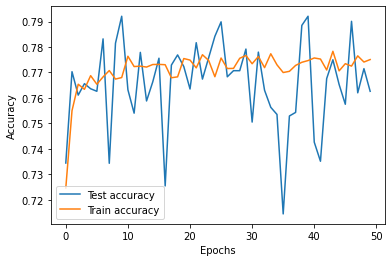

In [25]:
## Plotting the accuracies
import matplotlib.pyplot as plt
# test_acc = [acc.data for acc in test_epoch_acc]

plt.plot(val_accuracy, label='Test accuracy')
plt.plot(train_accuracy, label='Train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### Finetuning (2nd approach)

In [28]:
RESNET_PATH_B = './resnet18_b_2.pth'
resnet_18b_2, input_size = initialize_model('resnet', num_classes,
                                          feature_extract=False, use_pretrained=True)

In [33]:
learning_rate_2 = 10e-2
num_epochs_2 = 20
resnet_18b_2 = resnet_18b_2.to(device)
optimizer_2 = optim.Adam(resnet_18b_2.parameters(), lr = learning_rate_2)
criterion_2 = nn.CrossEntropyLoss()

In [34]:
val_acc_history = []
train_acc_history = []
resnet_18b_2, val_acc, train_acc = train_model(resnet_18b_2, dataloader_dict,
                           criterion_2, optimizer_2, num_epochs_2, is_inception=False)

Epoch 0/19
----------
train Loss: 1.1398 Acc: 0.5891
val Loss: 1.3145 Acc: 0.5603

Epoch 1/19
----------
train Loss: 1.0005 Acc: 0.6401
val Loss: 1.1216 Acc: 0.6131

Epoch 2/19
----------
train Loss: 0.9178 Acc: 0.6713
val Loss: 0.9841 Acc: 0.6458

Epoch 3/19
----------
train Loss: 0.8478 Acc: 0.6961
val Loss: 1.0519 Acc: 0.6272

Epoch 4/19
----------
train Loss: 0.7789 Acc: 0.7218
val Loss: 1.0505 Acc: 0.6312

Epoch 5/19
----------
train Loss: 0.7245 Acc: 0.7454
val Loss: 0.9486 Acc: 0.6796

Epoch 6/19
----------
train Loss: 0.6714 Acc: 0.7647
val Loss: 0.8807 Acc: 0.6945

Epoch 7/19
----------
train Loss: 0.6248 Acc: 0.7779
val Loss: 0.8501 Acc: 0.7139

Epoch 8/19
----------
train Loss: 0.5858 Acc: 0.7936
val Loss: 0.9297 Acc: 0.6988

Epoch 9/19
----------
train Loss: 0.5476 Acc: 0.8064
val Loss: 0.8639 Acc: 0.7221

Epoch 10/19
----------
train Loss: 0.5130 Acc: 0.8182
val Loss: 0.8247 Acc: 0.7297

Epoch 11/19
----------
train Loss: 0.4788 Acc: 0.8310
val Loss: 0.9720 Acc: 0.7102

Ep

RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "C:\Users\bokar\anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\Users\bokar\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\bokar\anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\bokar\anaconda3\lib\site-packages\torch\utils\data\dataset.py", line 330, in __getitem__
    return self.dataset[self.indices[idx]]
  File "C:\Users\bokar\anaconda3\lib\site-packages\torchvision\datasets\cifar.py", line 120, in __getitem__
    img = self.transform(img)
  File "C:\Users\bokar\anaconda3\lib\site-packages\torchvision\transforms\transforms.py", line 60, in __call__
    img = t(img)
  File "C:\Users\bokar\anaconda3\lib\site-packages\torchvision\transforms\transforms.py", line 97, in __call__
    return F.to_tensor(pic)
  File "C:\Users\bokar\anaconda3\lib\site-packages\torchvision\transforms\functional.py", line 142, in to_tensor
    return img.to(dtype=default_float_dtype).div(255)
RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:75] data. DefaultCPUAllocator: not enough memory: you tried to allocate 602112 bytes. Buy new RAM!


In [37]:
val_accuracy = []
train_accuracy = []
for acc in val_acc_history:
    val_accuracy.append(acc.item())
for acc in train_acc_history:
    train_accuracy.append(acc.item())

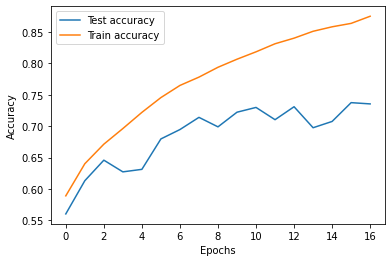

In [38]:
## Plotting the accuracies
import matplotlib.pyplot as plt
# test_acc = [acc.data for acc in test_epoch_acc]

plt.plot(val_accuracy, label='Test accuracy')
plt.plot(train_accuracy, label='Train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [39]:
torch.save(resnet_18b_2.state_dict(), RESNET_PATH_B)